In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tqdm.notebook as tq
from collections import defaultdict

from transformers import AutoTokenizer, T5Model

In [2]:
data = pd.read_csv("/kaggle/input/arxiv-dataset-preprocessed/arxiv-preprocessed_v3/arxiv-preprocessed_v3.tsv", sep = '\t')

In [3]:
len(data)

2231517

In [4]:
# For our task we remove the categories with small number of articles
columns = data.columns
# Find the frequencies of the articles in every category
categor_freq = data[columns[2:]].sum()/data.shape[0]
categor_freq

astro-ph    0.143782
cond-mat    0.155370
cs          0.225164
econ        0.003331
eess        0.028529
gr-qc       0.044439
hep-ex      0.022425
hep-lat     0.011905
hep-ph      0.076550
hep-th      0.070505
math        0.262658
math-ph     0.032991
nlin        0.017972
nucl-ex     0.010841
nucl-th     0.024175
physics     0.102532
q-bio       0.018315
q-fin       0.007448
quant-ph    0.059791
stat        0.047508
dtype: float64

In [5]:
data1 = data.sample(n = 10_000, random_state = 4)
data1.head(4)

,abstract,title,astro-ph,cond-mat,cs,econ,eess,gr-qc,hep-ex,hep-lat,...,math,math-ph,nlin,nucl-ex,nucl-th,physics,q-bio,q-fin,quant-ph,stat
1243377,"We present HiDe, a novel hierarchical reinfo...",Learning Functionally Decomposed Hierarchies f...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
412482,Precision measurements of the fundamental co...,Precision measurements of the Planck and Avoga...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49036,We make several new contributions to the stu...,On the complexity of proper holomorphic mappin...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
792982,We compute the three-loop QCD corrections to...,Massive three-loop form factor in the planar l...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data2 = data.copy()
data2.drop(data1.index, inplace = True)

In [7]:
data1 = pd.concat([data1, data2[data2.econ==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['q-fin']==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['q-bio']==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['nucl-ex']==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['nucl-th']==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['eess']==1][:1000]], ignore_index = True)
data1 = pd.concat([data1, data2[data2['nlin']==1][:1000]], ignore_index = True)

In [8]:
columns = data1.columns
# Find the frequencies of the articles in every category
categor_freq = data1[columns[2:]].sum()/data1.shape[0]
categor_freq

astro-ph    0.097294
cond-mat    0.122118
cs          0.186000
econ        0.061059
eess        0.078412
gr-qc       0.026941
hep-ex      0.021941
hep-lat     0.011412
hep-ph      0.076412
hep-th      0.049941
math        0.209471
math-ph     0.032118
nlin        0.074412
nucl-ex     0.072824
nucl-th     0.089765
physics     0.112588
q-bio       0.074471
q-fin       0.082412
quant-ph    0.041353
stat        0.060882
dtype: float64

In [9]:
len(data1)

17000

In [10]:
data1["combined"] = data1["title"] + ". " + data1["abstract"]
data1.drop(columns=["abstract", "title"], axis=1, inplace=True)

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data1, random_state=4, test_size=0.20, shuffle=True)
print(f"Train: {train_data.shape}, Test: {val_data.shape}")

Train: (13600, 21), Test: (3400, 21)


In [12]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-small')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [15]:
target_list = list(data1.columns)[:-1]
print(f'TARGETS: {target_list}, \nLEN: {len(target_list)}')

TARGETS: ['astro-ph', 'cond-mat', 'cs', 'econ', 'eess', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math', 'math-ph', 'nlin', 'nucl-ex', 'nucl-th', 'physics', 'q-bio', 'q-fin', 'quant-ph', 'stat'], 
LEN: 20


In [16]:
tr_ds = CustomDataset(train_data, tokenizer, MAX_LEN, target_list)
val_ds = CustomDataset(val_data, tokenizer, MAX_LEN, target_list)

In [17]:
train_dl = DataLoader(tr_ds, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_dl = DataLoader(val_ds, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [18]:
from transformers import AutoModel

In [19]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [20]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained('microsoft/deberta-v3-small', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.batchnorm = nn.BatchNorm1d(768)
        self.pooler = MeanPooling()
        self.linear = torch.nn.Linear(768, 20)

    def forward(self, input_ids, attn_mask):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask,
        )
        output = self.pooler(output.last_hidden_state, attn_mask)
        output_dropout = self.dropout(output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.bert_model.parameters():
#     param.requires_grad = False

model = model.to(device)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

In [22]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        loop.set_postfix(batch_loss=float(loss))

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [23]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()
    loop = tq.tqdm(enumerate(validation_loader), total=len(validation_loader), 
                      leave=True, colour='green')
    with torch.no_grad():
        for batch_idx, data in loop:
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

In [24]:
history = defaultdict(list)
best_loss = 0.15
best_acc = 0.9
data_dir = '/kaggle/working/'
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_dl, model, optimizer)
    val_acc, val_loss = eval_model(val_dl, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_loss < best_loss and val_acc > best_acc:
        torch.save(model.state_dict(), os.path.join(data_dir,f"ckpt_epoch{epoch}.pt"))
        best_loss = val_loss
        best_acc = val_acc

Epoch 1/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.2307, val_loss=0.1527 train_acc=0.9214, val_acc=0.9447
Epoch 2/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.1436, val_loss=0.1287 train_acc=0.9490, val_acc=0.9518
Epoch 3/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.1229, val_loss=0.1232 train_acc=0.9555, val_acc=0.9537
Epoch 4/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.1107, val_loss=0.1193 train_acc=0.9591, val_acc=0.9540
Epoch 5/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.1016, val_loss=0.1127 train_acc=0.9626, val_acc=0.9569
Epoch 6/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0935, val_loss=0.1132 train_acc=0.9655, val_acc=0.9563
Epoch 7/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0866, val_loss=0.1168 train_acc=0.9677, val_acc=0.9562
Epoch 8/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0797, val_loss=0.1121 train_acc=0.9707, val_acc=0.9576
Epoch 9/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0734, val_loss=0.1165 train_acc=0.9732, val_acc=0.9568
Epoch 10/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0676, val_loss=0.1192 train_acc=0.9754, val_acc=0.9568
Epoch 11/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0622, val_loss=0.1197 train_acc=0.9775, val_acc=0.9563
Epoch 12/15


  0%|          | 0/425 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

train_loss=0.0565, val_loss=0.1239 train_acc=0.9802, val_acc=0.9568
Epoch 13/15


  0%|          | 0/425 [00:00<?, ?it/s]

KeyboardInterrupt: 

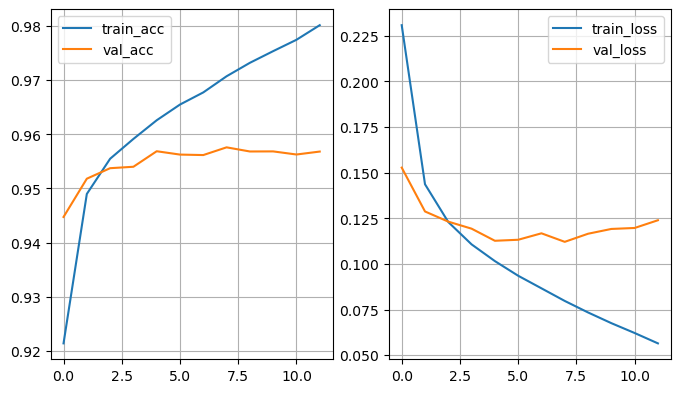

In [25]:
plt.figure(figsize = [8, 10])
plt.subplot(2, 2, 1)
plt.plot(history['train_acc'], label = 'train_acc')
plt.plot(history['val_acc'], label = 'val_acc')
plt.legend()
plt.grid()
plt.subplot(2, 2, 2)
plt.plot(history['train_loss'], label = 'train_loss')
plt.plot(history['val_loss'], label = 'val_loss')
plt.legend()
plt.grid()

In [ ]:
os.listdir('')

In [30]:
check = model.load_state_dict(torch.load('/kaggle/working/ckpt_epoch8.pt'))

In [ ]:
torch.save(model, '/kaggle/working/model.pt')

In [ ]:
model = torch.load('/kaggle/working/model.pt')

In [37]:
raw_text = "Prediction of cancer driver genes and mutations: the potential of integrative computational frameworks"

In [38]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [39]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = nn.functional.softmax(output, dim = 1).detach().cpu()
# thresholding at 0.5
output = output.flatten().numpy()
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
    print(f"Label: {target_list[idx]}, proba: {float(output[idx])*100}")

Title: Prediction of cancer driver genes and mutations: the potential of integrative computational frameworks
Label: astro-ph, proba: 0.11037413496524096
Label: cond-mat, proba: 0.22395707201212645
Label: cs, proba: 0.12963280314579606
Label: econ, proba: 0.05575352115556598
Label: eess, proba: 0.04729746142402291
Label: gr-qc, proba: 0.03296571085229516
Label: hep-ex, proba: 0.03555283765308559
Label: hep-lat, proba: 0.028567505069077015
Label: hep-ph, proba: 0.09343647980131209
Label: hep-th, proba: 0.0911316485144198
Label: math, proba: 0.20940089598298073
Label: math-ph, proba: 0.03838013217318803
Label: nlin, proba: 0.14588525518774986
Label: nucl-ex, proba: 0.14641900779679418
Label: nucl-th, proba: 0.05791513831354678
Label: physics, proba: 0.20968446042388678
Label: q-bio, proba: 98.08345437049866
Label: q-fin, proba: 0.1133270445279777
Label: quant-ph, proba: 0.05371267907321453
Label: stat, proba: 0.09314403869211674


In [34]:
tokenizer.save_pretrained('/kaggle/working/')

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/spm.model',
 '/kaggle/working/added_tokens.json',
 '/kaggle/working/tokenizer.json')

In [ ]:
os.listdir('/kaggle/working/')

In [ ]:
from tqdm.notebook import tqdm 
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in tqdm(data_loader):
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values

In [ ]:
titles, predictions, prediction_probs, target_values = get_predictions(model, val_dl)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(target_values, predictions, target_names=target_list))

In [ ]:
bert = BertModel.from_pretrained('bert-base-uncased', return_dict = True)

In [ ]:
bert.save_pretrained('/kaggle/working/')

In [36]:
model.bert_model.save_pretrained('/kaggle/working/')